# CIFAR10 90% test accuracy
This notebook is a (hopefully cleaner) reimplementation of a [kaggle notebook](https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min).  
The first goal is to familiarize my self with more advanced architecture and training method than the baseline tutorial model.  
The second goal is to interpret the trained model.  

## Setup

### Imports

In [1]:
from datetime import datetime

import torch
from torch import nn
from torch import Tensor
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    RandomCrop,
    RandomHorizontalFlip,
)

from models import ResNet9
from trainer import Trainer
from data_loaders import DeviceDataLoader as DL

### Search for an accelerator

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Datasets, Transforms and Data loaders

### Transforms

In [3]:
CHANNELS_MEAN = (0.4914, 0.4822, 0.4465)
CHANNELS_STD = (0.2023, 0.1994, 0.2010)

training_transform = Compose([
    RandomCrop(32, padding=4, padding_mode="constant"),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(CHANNELS_MEAN, CHANNELS_STD, inplace=True),
])
validation_transform = Compose([ToTensor(), Normalize(CHANNELS_MEAN, CHANNELS_STD)])

### Datasets

In [4]:
training_dataset = CIFAR10(root="./datasets/cifar10/", train=True, download=True, transform=training_transform)
validation_dataset = CIFAR10(root="./datasets/cifar10/", train=False, transform=validation_transform)

Files already downloaded and verified


### Datasets loaders

In [5]:
BATCH_SIZE = 400
training_dl = DL(training_dataset, BATCH_SIZE, shuffle=True, num_workers=3, device=device, pin_memory=True)
validation_dl = DL(validation_dataset, BATCH_SIZE * 2, num_workers=3, device=device, pin_memory=True)

### Dataset visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


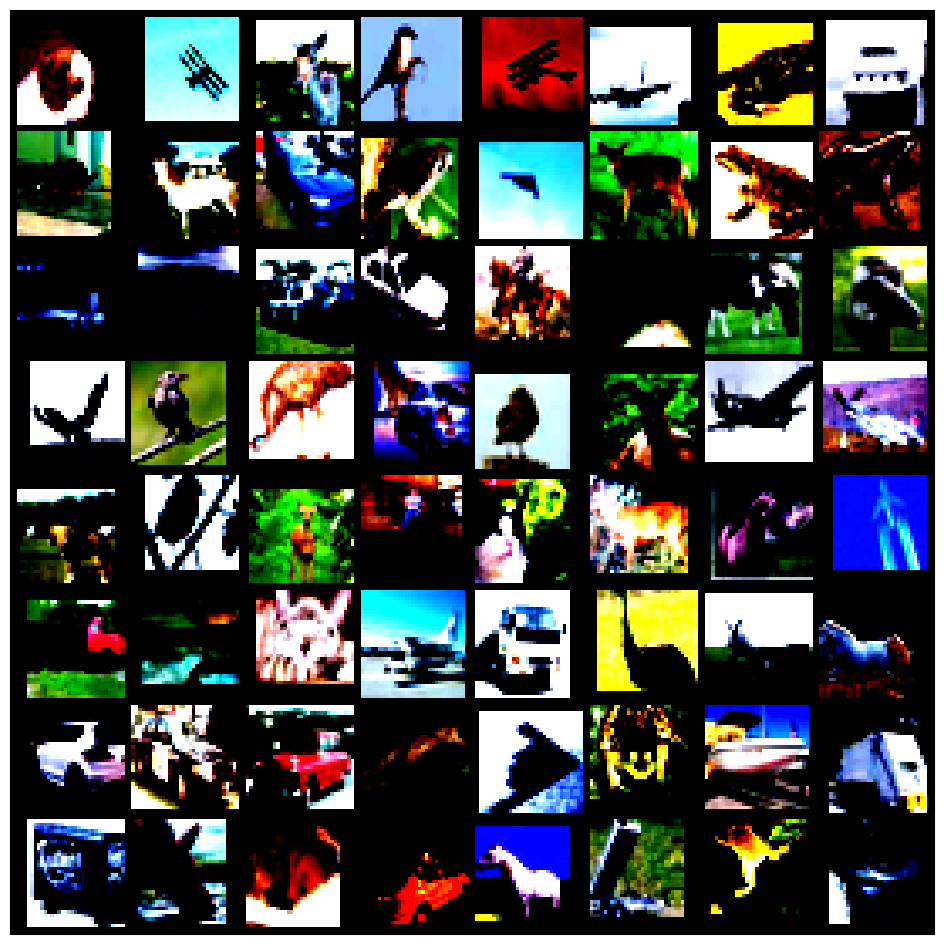

In [6]:
images, labels = next(iter(training_dl))
# Ironically, we have to bring the batch back to the CPU
images, labels = images.cpu(), labels.cpu()
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))

## Model definition

In [7]:
model = ResNet9(3, 10).cuda()
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [8]:
EPOCHS = 8
MAX_LR = 0.01
optimizer = Adam(model.parameters(), MAX_LR, weight_decay=1e-4)
lr_scheduler = OneCycleLR(optimizer, MAX_LR, epochs=EPOCHS, steps_per_epoch=len(training_dl))
trainer = Trainer(
    model,
    optimizer,
    lr_scheduler = lr_scheduler,
)

In [ ]:
%%time

training_metrics = trainer.optimize_nn(
    epochs=EPOCHS,
    train_dl=training_dl,
    test_dl=validation_dl,
    plt_kwargs=dict(x="epoch", y=["train_loss", "train_accuracy", "test_loss", "test_accuracy"], height=600),
).set_index("epoch")


FigureWidget({
    'data': [{'hovertemplate': 'variable=train_loss<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_loss',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_loss',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '31b34ddf-95bf-4c40-a94d-d36b9efed6b5',
              'x': array([0]),
              'xaxis': 'x4',
              'y': array([2.30764308]),
              'yaxis': 'y4'},
             {'hovertemplate': 'variable=train_accuracy<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_accuracy',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_accuracy',
              'orientation': 'v',
   

RuntimeError: Parent directory models does not exist.

In [ ]:
! mkdir -p "models"
torch.save(model.state_dict(), "./models/" + model.name + ".pth")

In [12]:
training_metrics

,step,date,test_loss,test_accuracy,train_loss,train_accuracy,lr,betas,eps,weight_decay,...,foreach,capturable,differentiable,fused,initial_lr,max_lr,min_lr,max_momentum,base_momentum,params
epoch,,,,,,,,,,,,,,,,,,,,,
0,0,2025-06-02 12:28:38.365283,2.307103,0.1020,2.307643,0.10142,4.000000e-04,"(0.95, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,125,2025-06-02 12:28:48.928481,1.373076,0.5632,1.397531,0.50554,3.977978e-03,"(0.9127293918012431, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,250,2025-06-02 12:28:58.973208,1.895364,0.5349,0.985439,0.66442,9.377776e-03,"(0.8564814966251822, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,375,2025-06-02 12:29:08.995783,0.660958,0.7703,0.756026,0.74512,9.711959e-03,"(0.8528804229767982, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,500,2025-06-02 12:29:19.015630,0.663025,0.7712,0.538200,0.81476,8.099881e-03,"(0.8690012658510454, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,625,2025-06-02 12:29:29.085136,0.509924,0.8224,0.447955,0.84628,5.537536e-03,"(0.8946248203244738, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,750,2025-06-02 12:29:39.242056,0.416673,0.8601,0.338738,0.88314,2.810414e-03,"(0.9218961447360182, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
7,875,2025-06-02 12:29:49.325637,0.331596,0.8902,0.243642,0.91634,7.545199e-04,"(0.9424551709111096, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
8,1000,2025-06-02 12:29:59.405546,0.290838,0.9019,0.179963,0.94098,9.035484e-08,"(0.9499994964496002, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
